In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
import os
import time
import numpy as np
import pandas as pd
from seaborn import countplot,lineplot, barplot
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [2]:
tr = pd.read_csv('../input/X_train.csv')
te = pd.read_csv('../input/X_test.csv')
target = pd.read_csv('../input/y_train.csv')
ss = pd.read_csv('../input/sample_submission.csv')

In [3]:
tr.columns.values.tolist()

['row_id',
 'series_id',
 'measurement_number',
 'orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

In [4]:
import math
def quaternion_to_euler(x, y, z, w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [5]:
x, y, z, w = tr['orientation_X'].tolist(), tr['orientation_Y'].tolist(), tr['orientation_Z'].tolist(), tr['orientation_W'].tolist()
nx, ny, nz = [], [], []
for i in range(len(x)):
    xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
    nx.append(xx)
    ny.append(yy)
    nz.append(zz)
# tr_new = tr.copy()
tr['euler_x'] = nx
tr['euler_X'] = nx
tr['euler_Y'] = ny
tr['euler_Z'] = nz
# tr_new = tr

In [6]:
x, y, z, w = te['orientation_X'].tolist(), te['orientation_Y'].tolist(), te['orientation_Z'].tolist(), te['orientation_W'].tolist()
nx, ny, nz = [], [], []
for i in range(len(x)):
    xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
    nx.append(xx)
    ny.append(yy)
    nz.append(zz)
# tr_new = tr.copy()
te['euler_X'] = nx
te['euler_Y'] = ny
te['euler_Z'] = nz

In [7]:
tr_concat = tr.merge(target, on='series_id')

In [8]:
# hard_tile_series_id = tr_concat[tr_concat["surface"]=="hard_tiles"].index.values.tolist()[0]
# concrete_series_id = tr_concat[tr_concat["surface"]=="concrete"].index.values.tolist()[0]

In [9]:
tr_concat[tr_concat["surface"]=="hard_tiles"]
print(1)

1


In [10]:
hard_tile_series_id = 27
concrete_series_id = 1
hard_tile_series_id_2 = 1671

In [11]:
series_0 = tr_concat[tr_concat['series_id']==1]
measurement_series = series_0['measurement_number']
orientation_X = series_0['orientation_X']
orientation_Y = series_0['orientation_Y']
angular_velocity_X = series_0['angular_velocity_X']
angular_velocity_Y = series_0['angular_velocity_Y']
linear_acceleration_X = series_0['linear_acceleration_X']
linear_acceleration_Y = series_0['linear_acceleration_Y']
euler_x = series_0['euler_x']


In [12]:
measurement_series_20 = measurement_series[0:5]
orientation_X_20  = orientation_X[0:5]
angular_velocity_X_20 = angular_velocity_X[0:5]
linear_acceleration_X_20 = linear_acceleration_X[0:5]
euler_x_20 = euler_x[0:5]

In [13]:
series_1 = tr_concat[tr_concat['series_id']==27]
measurement_series_1 = series_1['measurement_number']
orientation_X_1 = series_1['orientation_X']
orientation_Y_1 = series_1['orientation_Y']
angular_velocity_X_1 = series_1['angular_velocity_X']
angular_velocity_Y_1 = series_1['angular_velocity_Y']
linear_acceleration_X_1 = series_1['linear_acceleration_X']
linear_acceleration_Y_1 = series_1['linear_acceleration_Y']
euler_x_1 = series_1['euler_x']

In [14]:
series_2 = tr_concat[tr_concat['series_id']==1671]
measurement_series_2 = series_2['measurement_number']
orientation_X_2 = series_2['orientation_X']
orientation_Y_2 = series_2['orientation_Y']
angular_velocity_X_2 = series_2['angular_velocity_X']
angular_velocity_Y_2 = series_2['angular_velocity_Y']
linear_acceleration_X_2 = series_2['linear_acceleration_X']
linear_acceleration_Y_2 = series_2['linear_acceleration_Y']
euler_x_2 = series_2['euler_x']

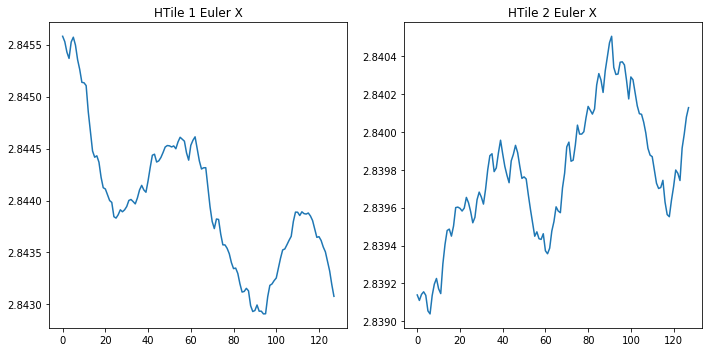

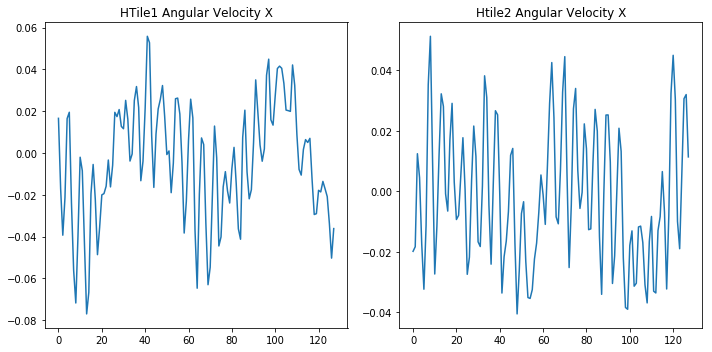

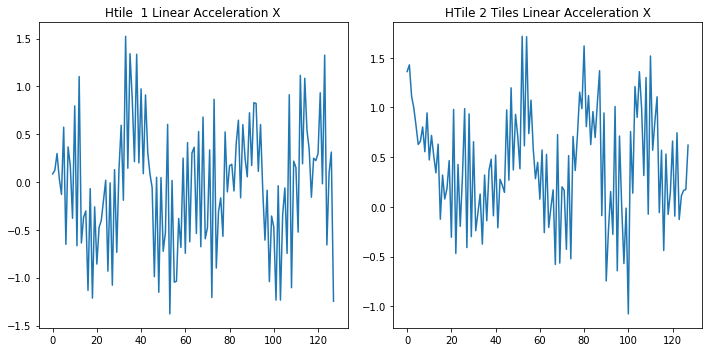

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))
ax1.plot(measurement_series,euler_x_1 )
ax1.set_title('HTile 1 Euler X')
ax2.plot(measurement_series,euler_x_2 )
ax2.set_title('HTile 2 Euler X')
plt.tight_layout()

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))
ax1.plot(measurement_series,angular_velocity_X_1 )
ax1.set_title('HTile1 Angular Velocity X')
ax2.plot(measurement_series,angular_velocity_X_2 )
ax2.set_title('Htile2 Angular Velocity X')
plt.tight_layout()


f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))
ax1.plot(measurement_series,linear_acceleration_X_1 )
ax1.set_title('Htile  1 Linear Acceleration X')
ax2.plot(measurement_series,linear_acceleration_X_2 )
ax2.set_title('HTile 2 Tiles Linear Acceleration X')
plt.tight_layout()
# plt.plot(measurement_series,euler_x_1 )
# plt.title("hard_tile")
# plt.xlabel('time')
# plt.ylabel('euler_x')
# # plt.show()
# # plt.subplot(1,1,1)

# plt.plot(measurement_series,angular_velocity_X_1 )
# plt.title("hard_tile")
# plt.xlabel('time')
# plt.ylabel('angular_velocity_X')
# # plt.subplot(1,2,2)
# # plt.tight_layout()

# plt.show()

# plt.plot(measurement_series, linear_acceleration_X_1)
# plt.title("hard_tile")
# plt.xlabel('time')
# plt.ylabel('linear_acceleration_X')
# plt.show()

In [16]:
angular_velocity_X_1
# 3459   -0.021373
# 3460    0.016481
angular_velocity_X_2

213888   -0.019839
213889   -0.018319
213890    0.012431
213891    0.004485
213892   -0.017485
213893   -0.032358
213894   -0.011310
213895    0.035192
213896    0.051248
213897    0.010060
213898   -0.027335
213899   -0.011535
213900    0.012100
213901    0.032227
213902    0.028063
213903   -0.000833
213904   -0.006536
213905    0.017022
213906    0.029080
213907    0.002994
213908   -0.009327
213909   -0.007957
213910    0.004968
213911    0.017719
213912    0.000592
213913   -0.027436
213914   -0.021729
213915    0.003537
213916    0.021577
213917    0.011542
            ...   
213986   -0.038394
213987   -0.038986
213988   -0.017861
213989   -0.013077
213990   -0.031362
213991   -0.030385
213992   -0.011791
213993   -0.011501
213994   -0.016940
213995   -0.030914
213996   -0.036889
213997   -0.016527
213998   -0.008307
213999   -0.033018
214000   -0.033596
214001   -0.012980
214002   -0.008358
214003    0.006524
214004   -0.006898
214005   -0.032288
214006   -0.007881
214007    0.

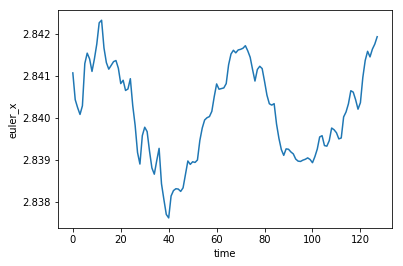

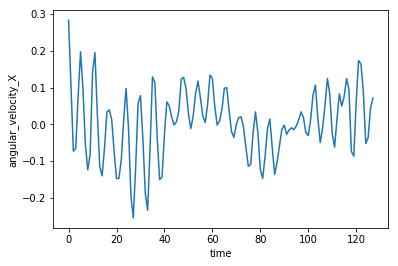

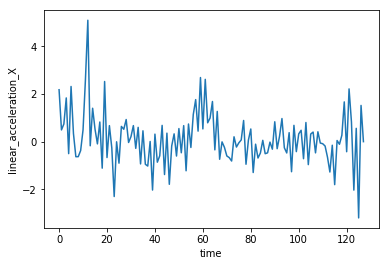

In [17]:
# plt.plot(measurement_series_20,orientation_X_20 )
# plt.xlabel('time')
# plt.ylabel('orientation_X')
# plt.show()

plt.plot(measurement_series,euler_x )
plt.xlabel('time')
plt.ylabel('euler_x')
plt.show()

plt.plot(measurement_series,angular_velocity_X )
plt.xlabel('time')
plt.ylabel('angular_velocity_X')
plt.show()

plt.plot(measurement_series, linear_acceleration_X)
plt.xlabel('time')
plt.ylabel('linear_acceleration_X')
plt.show()

In [18]:
tr.columns.values.tolist()

['row_id',
 'series_id',
 'measurement_number',
 'orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z',
 'euler_x',
 'euler_X',
 'euler_Y',
 'euler_Z']

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
train_labels = target['surface']
# random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50)
# random_forest.fit(tr_a, train_labels)
# predictions = random_forest.predict(test_a)
# print(1)

In [21]:
from IPython.display import HTML
import base64
def create_download_link(df, title = "Download ", filename = "data.csv"):  
    title = title + filename
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [22]:
# submit_df = pd.DataFrame(test_a.reset_index()['series_id'],columns=['series_id'])
# # submit_df = pd.DataFrame(te.reset_index()['series_id'],columns=['series_id'])
# submit_df['surface'] = predictions

In [23]:
# create_download_link(submit_df, filename="13th_sol_simple_feature_eng.csv")

In [24]:
# submit_df['surface'].value_counts()

In [25]:
def feature_engineering(df, feature, train_or_test):
    grouped = train_or_test.groupby('series_id')
    df[feature + "_X_var_Y"] =  grouped.apply(lambda x: x[feature + "_X"].cov(x[feature + "_Y"]))
    df[feature + "_Y_var_Z"] =  grouped.apply(lambda x: x[feature + "_Y"].cov(x[feature + "_Z"]))
    df[feature + "_Z_var_X"] =  grouped.apply(lambda x: x[feature + "_Z"].cov(x[feature + "_X"]))
    df[feature + "_X_mean"] = grouped[feature + "_X"].mean()
    df[feature + "_Y_mean"] = grouped[feature + "_Y"].mean()
    df[feature + "_Z_mean"] = grouped[feature + "_Z"].mean()
    df[feature + "_X_var"] = grouped[feature + "_X"].var()
    df[feature + "_Y_var"] = grouped[feature + "_Y"].var()
    df[feature + "_Z_var"] = grouped[feature + "_Z"].var()
    return df

In [26]:
tr_a = pd.DataFrame()
tr_a = feature_engineering(tr_a,'linear_acceleration',tr)
test_a = pd.DataFrame()
test_a = feature_engineering(test_a,'linear_acceleration',te)


In [27]:
tr_b = tr_a.copy()
tr_b = feature_engineering(tr_b,'angular_velocity', tr)
test_b = test_a.copy()
test_b = feature_engineering(test_b,'angular_velocity', te)

In [28]:
tr_c = tr_b.copy()
tr_c = feature_engineering(tr_c,"euler", tr)
test_c = test_b.copy()
test_c = feature_engineering(test_c,'euler', te)

In [29]:
test_c.columns.values.tolist()

['linear_acceleration_X_var_Y',
 'linear_acceleration_Y_var_Z',
 'linear_acceleration_Z_var_X',
 'linear_acceleration_X_mean',
 'linear_acceleration_Y_mean',
 'linear_acceleration_Z_mean',
 'linear_acceleration_X_var',
 'linear_acceleration_Y_var',
 'linear_acceleration_Z_var',
 'angular_velocity_X_var_Y',
 'angular_velocity_Y_var_Z',
 'angular_velocity_Z_var_X',
 'angular_velocity_X_mean',
 'angular_velocity_Y_mean',
 'angular_velocity_Z_mean',
 'angular_velocity_X_var',
 'angular_velocity_Y_var',
 'angular_velocity_Z_var',
 'euler_X_var_Y',
 'euler_Y_var_Z',
 'euler_Z_var_X',
 'euler_X_mean',
 'euler_Y_mean',
 'euler_Z_mean',
 'euler_X_var',
 'euler_Y_var',
 'euler_Z_var']

In [30]:
tr_c.columns.values.tolist()

['linear_acceleration_X_var_Y',
 'linear_acceleration_Y_var_Z',
 'linear_acceleration_Z_var_X',
 'linear_acceleration_X_mean',
 'linear_acceleration_Y_mean',
 'linear_acceleration_Z_mean',
 'linear_acceleration_X_var',
 'linear_acceleration_Y_var',
 'linear_acceleration_Z_var',
 'angular_velocity_X_var_Y',
 'angular_velocity_Y_var_Z',
 'angular_velocity_Z_var_X',
 'angular_velocity_X_mean',
 'angular_velocity_Y_mean',
 'angular_velocity_Z_mean',
 'angular_velocity_X_var',
 'angular_velocity_Y_var',
 'angular_velocity_Z_var',
 'euler_X_var_Y',
 'euler_Y_var_Z',
 'euler_Z_var_X',
 'euler_X_mean',
 'euler_Y_mean',
 'euler_Z_mean',
 'euler_X_var',
 'euler_Y_var',
 'euler_Z_var']

In [31]:
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50)
random_forest.fit(tr_c, train_labels)
predictions = random_forest.predict(test_c)

In [32]:
submit_df = pd.DataFrame(test_c.reset_index()['series_id'],columns=['series_id'])
submit_df['surface'] = predictions
create_download_link(submit_df, filename="14th_sol_simple_feature_eng.csv")

In [33]:
submit_df["surface"].value_counts()

concrete                  934
soft_pvc                  762
wood                      676
soft_tiles                420
tiled                     413
fine_concrete             281
hard_tiles_large_space    226
carpet                     99
hard_tiles                  5
Name: surface, dtype: int64

In [34]:
# linear: .
# polynomial
# rbf
# sigmoid

In [35]:
from sklearn.svm import SVC 
# rbf
svclassifier_rbc = SVC(kernel='rbf')  
svclassifier_rbc.fit(tr_c, train_labels)  
predictions_svm_rbc = svclassifier_rbc.predict(test_c)  
submit_svm_rbf = pd.DataFrame(test_c.reset_index()['series_id'],columns=['series_id'])
submit_svm_rbf['surface'] = predictions_svm_rbc

# linear
svclassifier_linear = SVC(kernel='linear')  
svclassifier_linear.fit(tr_c, train_labels)  
predictions_svm_linear = svclassifier_linear.predict(test_c) 
submit_svm_linear = pd.DataFrame(test_c.reset_index()['series_id'],columns=['series_id'])
submit_svm_linear['surface'] = predictions_svm_linear

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [36]:
submit_svm_rbf['surface'].value_counts() - submit_svm_linear['surface'].value_counts()

carpet                      8
concrete                 -119
fine_concrete             144
hard_tiles_large_space     69
soft_pvc                   12
soft_tiles                 13
tiled                      35
wood                     -162
Name: surface, dtype: int64

In [37]:

diff = pd.DataFrame()

def prediction_diffs(df1, df2):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-37-36d76a11426a>, line 5)

In [38]:
kernel_types = ['linear','rbf','sigmoid']
# 'polynomial'
prediction_svm  = {}
submit_svm = {}
for kernel_type in kernel_types:
    svm_classifier = SVC(kernel=kernel_type)  
    svm_classifier.fit(tr_c, train_labels)  
    prediction_svm[kernel_type] = svm_classifier.predict(test_c) 
    submit_df_svm = pd.DataFrame(test_c.reset_index()['series_id'],columns=['series_id'])
    submit_df_svm['surface'] = prediction_svm[kernel_type]
    submit_svm[kernel_type] = submit_df_svm

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [39]:
submit_svm['rbf']['surface'].value_counts()- submit_svm['linear']['surface'].value_counts() 

carpet                      8
concrete                 -119
fine_concrete             144
hard_tiles_large_space     69
soft_pvc                   12
soft_tiles                 13
tiled                      35
wood                     -162
Name: surface, dtype: int64